<a href="https://colab.research.google.com/github/paulmyr/jaxley/blob/main/notebooks/jaxley_test_lif_surrogate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use custom jaxley build<br>
-> fork in github.com/paulmyr/jaxley.git

In [24]:
!git clone https://github.com/paulmyr/jaxley.git
!pip install tridiax

import jax
import jax.numpy as jnp
from jax import grad, value_and_grad
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, '/content/jaxley')

import jaxley as jx


fatal: destination path 'jaxley' already exists and is not an empty directory.


/content/jaxley/jaxley/channels/non_capacitive/spike.py:30: UserWarning: The `Fire` channel does not support surrogate gradients. Its gradient will be zero after every spike.
  warn(


Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 external_states. See `.externals` for details.


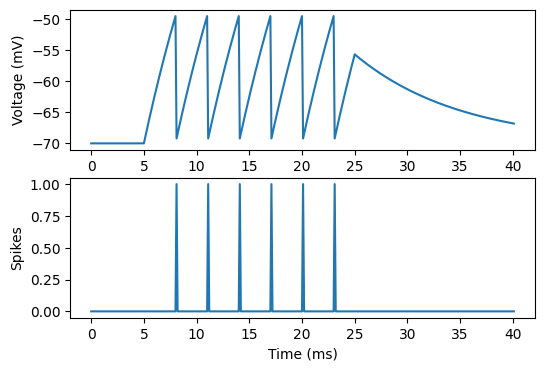

In [25]:
# Leaky integrate-and-fire neurons.
from jaxley.channels import Leak, Fire

cell = jx.Cell()
cell.insert(Leak())
cell.insert(Fire())
cell.record("v")
cell.record("Fire_spikes")

dt = 0.1
t_max = 40.0

cell.stimulate(jx.step_current(5.0, 20.0, 0.005, dt, t_max))
v = jx.integrate(cell, delta_t=dt)
time_vec = jnp.arange(0, t_max + 2 * dt, dt)
fig, ax = plt.subplots(2, 1, figsize=(6, 4))
_ = ax[0].plot(time_vec, v[0])
_ = ax[1].plot(time_vec, v[1])
_ = ax[0].set_ylabel("Voltage (mV)")
_ = ax[1].set_ylabel("Spikes")
_ = ax[1].set_xlabel("Time (ms)")

In [26]:
!mkdir figures

mkdir: cannot create directory ‘figures’: File exists


# Visualize gradients

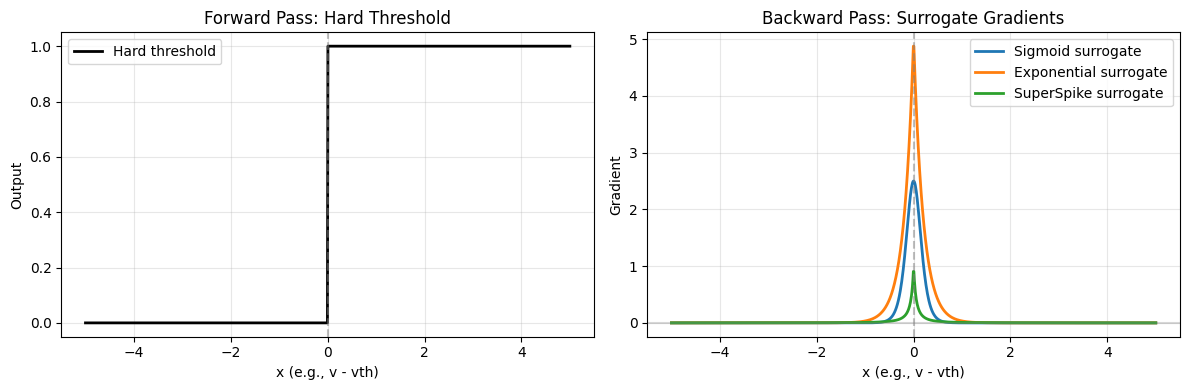

In [27]:
import matplotlib.pyplot as plt
from jax import grad, value_and_grad


x = jnp.linspace(-5, 5, 1000)

# Forward pass values
hard_threshold = (x >= 0).astype(jnp.float32)
sigmoid_surrogate = jax.vmap(
    lambda x: jx.channels.non_capacitive.spike._heaviside_with_sigmoid_surrogate(x, slope=10.0)
)(x)

# Backward pass (gradients)
def compute_gradient(fn, x_val):
    return grad(lambda x: fn(x))(x_val)

grad_sigmoid = jax.vmap(
    lambda x: compute_gradient(
        lambda x: jx.channels.non_capacitive.spike._heaviside_with_sigmoid_surrogate(x, slope=10.0), x
    )
)(x)

grad_exponential = jax.vmap(
    lambda x: compute_gradient(
        lambda x: jx.channels.non_capacitive.spike._heaviside_with_exponential_surrogate(x, beta=5.0), x
    )
)(x)

grad_superspike = jax.vmap(
    lambda x: compute_gradient(
        lambda x: jx.channels.non_capacitive.spike._heaviside_with_superspike_surrogate(x, beta=10.0), x
    )
)(x)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot forward pass
axes[0].plot(x, hard_threshold, 'k-', linewidth=2, label='Hard threshold')
axes[0].axvline(0, color='gray', linestyle='--', alpha=0.5)
axes[0].set_xlabel('x (e.g., v - vth)')
axes[0].set_ylabel('Output')
axes[0].set_title('Forward Pass: Hard Threshold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot backward pass (gradients)
axes[1].plot(x, grad_sigmoid, label='Sigmoid surrogate', linewidth=2)
axes[1].plot(x, grad_exponential, label='Exponential surrogate', linewidth=2)
axes[1].plot(x, grad_superspike, label='SuperSpike surrogate', linewidth=2)
axes[1].axvline(0, color='gray', linestyle='--', alpha=0.5)
axes[1].axhline(0, color='gray', linestyle='-', alpha=0.3)
axes[1].set_xlabel('x (e.g., v - vth)')
axes[1].set_ylabel('Gradient')
axes[1].set_title('Backward Pass: Surrogate Gradients')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('figures/surrogate_gradients_comparison.png', dpi=150)
plt.show()




# LIF neuron with surrogate gradients

Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Simulating LIF neuron for 40.0 ms with dt=0.1 ms
Added 1 external_states. See `.externals` for details.


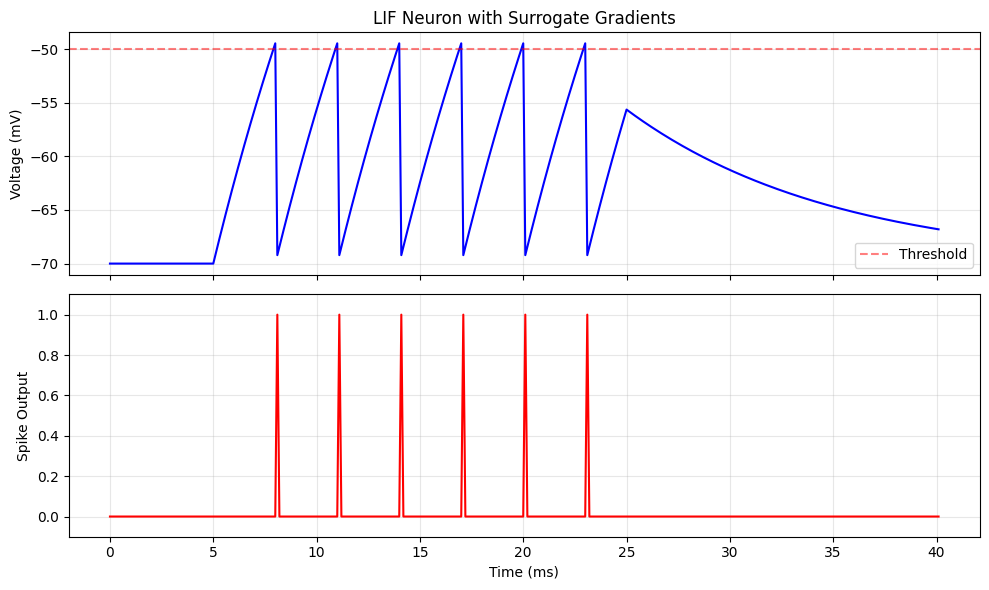

In [28]:
from jaxley.channels import Leak, Fire, FireSurrogate


cell = jx.Cell()
cell.insert(Leak())
cell.insert(FireSurrogate(surrogate_type="sigmoid", surrogate_slope=10.0))
cell.record("v")
cell.record("FireSurrogate_spikes")

dt = 0.1
t_max = 40.0

print(f"Simulating LIF neuron for {t_max} ms with dt={dt} ms")

current = jx.step_current(5.0, 20.0, 0.005, dt, t_max)
cell.stimulate(current)
voltages = jx.integrate(cell, delta_t=dt)

num_points = len(voltages[0])
time_vec = jnp.arange(num_points) * dt
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

axes[0].plot(time_vec, voltages[0], 'b-', linewidth=1.5)
axes[0].axhline(-50, color='r', linestyle='--', alpha=0.5, label='Threshold')
axes[0].set_ylabel('Voltage (mV)')
axes[0].set_title('LIF Neuron with Surrogate Gradients')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(time_vec, voltages[1], 'r-', linewidth=1.5)
axes[1].set_ylabel('Spike Output')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylim([-0.1, 1.1])
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('figures/lif_simulation_surrogate.png', dpi=150)
plt.show()


# Gradient for optimisation

In [29]:
cell = jx.Cell()
cell.insert(Leak())
cell.insert(FireSurrogate(surrogate_type="sigmoid", surrogate_slope=10.0))
cell.record("v")
cell.record("FireSurrogate_spikes")
cell.make_trainable("FireSurrogate_vth")

params = cell.get_parameters()
print(params)

cell.stimulate(current)

cell_original = jx.Cell()
cell_original.insert(Leak())
cell_original.insert(Fire())
cell_original.record("v")
cell_original.record("Fire_spikes")
cell_original.stimulate(current)
cell_original.make_trainable("Fire_vth")

params_original = cell_original.get_parameters()
print(params_original)

cell_original.stimulate(current)

# Define loss function: maximize number of spikes
def loss_fn(params):
    voltages = jx.integrate(cell, params=params, delta_t=dt)
    spike_output = voltages[1]  # FireSurrogate_spikes
    # Loss = negative sum of spikes (we want to maximize spikes)
    return -jnp.sum(spike_output)

def loss_fn_orig(params):
    voltages = jx.integrate(cell_original, params=params, delta_t=dt)
    spike_output = voltages[1]  # FireSurrogate_spikes
    # Loss = negative sum of spikes (we want to maximize spikes)
    return -jnp.sum(spike_output)

# Compute gradient
loss_val, grads = value_and_grad(loss_fn)(params)

print("-" * 50)
print("Gradient with surrogate")
print("-" * 50)

print(f"Loss value: {loss_val:.4f}")
print(f"Gradient w.r.t. Leak_gLeak: {grads[0]['FireSurrogate_vth'][0]:.6e}")

if grads[0]['FireSurrogate_vth'][0] != 0:
    print("Non-zero gradient computed!")
    print("backpropagation successful")
else:
    print("err: grad is 0")


# no surrogate
loss_val, grads = value_and_grad(loss_fn_orig)(params_original)

print("-" * 50)
print("Gradient no surrogate")
print("-" * 50)

print(f"Loss value: {loss_val:.4f}")
print(f"Gradient: {grads[0]['Fire_vth'][0]:.6e}")

if grads[0]['Fire_vth'][0] == 0:
    print("Zero gradient computed!")
    print("backpropagation failed")


Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Number of newly added trainable parameters: 1. Total number of trainable parameters: 1
[{'FireSurrogate_vth': Array([-50.], dtype=float32)}]
Added 1 external_states. See `.externals` for details.


/content/jaxley/jaxley/channels/non_capacitive/spike.py:30: UserWarning: The `Fire` channel does not support surrogate gradients. Its gradient will be zero after every spike.
  warn(


Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 external_states. See `.externals` for details.
Number of newly added trainable parameters: 1. Total number of trainable parameters: 1
[{'Fire_vth': Array([-50.], dtype=float32)}]
Added 1 external_states. See `.externals` for details.
--------------------------------------------------
Gradient with surrogate
--------------------------------------------------
Loss value: -6.0000
Gradient w.r.t. Leak_gLeak: 1.280372e+06
Non-zero gradient computed!
backpropagation successful
--------------------------------------------------
Gradient no surrogate
--------------------------------------------------
Loss value: -14.0000
Gradient: 0.000000e+00
Zero gradient computed!
backpropagation failed
